# Cloud and Cognitive Environments

Este projeto tem como objetivo aprofundar os conhecimentos em Ambientes Cognitivos, por meio da aplicação prática de ferramentas de computação em nuvem e APIs cognitivas na construção de soluções inteligentes.
O foco dessa aplicação será na extração de dados de documentos e checagem de identidade utilizandos documentos fornecidos por um usuário.

# Etapa 1 - Upload dos documentos

In [ ]:
!pip install azure-storage-blob


In [ ]:
## Upload dos arquivos
#from google.colab import files
#uploaded = files.upload()

O código a seguir foi utilizado para subir os documentos salvos em uploaded no container documentos relativo a uma conta de armazenamento na Azure.

In [ ]:
from azure.storage.blob import BlobServiceClient

# Substitua pela sua connection string
connection_string = "-----"
container_name = "documentos"

# Inicializar cliente
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)



In [ ]:
#for filename in uploaded.keys():
#    with open(filename, "rb") as data:
#        container_client.upload_blob(name=filename, data=data, overwrite=True)
#        print(f"{filename} enviado com sucesso para o Azure.")

# Etapa 2 - Acesso aos Arquivos do Container Azure Blob Storage

In [ ]:
from azure.storage.blob import BlobServiceClient

# Função para ler um arquivo como bytes
def baixar_arquivo(nome_arquivo):
    blob_client = container_client.get_blob_client(nome_arquivo)
    blob_bytes = blob_client.download_blob().readall()
    return blob_bytes

# Ler os três arquivos
cnh_bytes = baixar_arquivo("CNH.jpg")
comprovante_bytes = baixar_arquivo("Comprovante de endereço.pdf")
selfie_bytes = baixar_arquivo("foto.jpg")


In [ ]:
# Conferindo se os arquivos foram lidos
from PIL import Image
from io import BytesIO
from IPython.display import display

# Mostrar CNH
display(Image.open(BytesIO(selfie_bytes)))

# Etapa 3 - Criação de um recurso Document Intelligence (form recognizer)

Nessa etapa foi criado um recurso diretamente pela Azure

In [ ]:
!pip install azure-ai-formrecognizer --quiet


In [ ]:
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential

form_recognizer_key = ""
form_recognizer_endpoint = ""

form_client = DocumentAnalysisClient(
    endpoint=form_recognizer_endpoint,
    credential=AzureKeyCredential(form_recognizer_key)
)


# Etapa 4 - Envio da CNH para o Azure Form Recognizer e extração do nome e CPF

In [ ]:
from io import BytesIO

# Enviar imagem da CNH para o Form Recognizer
poller = form_client.begin_analyze_document(
    model_id="prebuilt-idDocument",
    document=BytesIO(cnh_bytes)
)
result = poller.result()

# Acessar os campos estruturados dentro de result.documents
for document in result.documents:
    print("---- Documento analisado ----")
    for name, field in document.fields.items():
        print(f"{name}: {field.value} (confiança: {field.confidence})")




In [ ]:
fields = document.fields

first = fields.get("FirstName").value if "FirstName" in fields else ""
last = fields.get("LastName").value if "LastName" in fields else ""

nome_completo = f"{first} {last}".strip()
print("Nome completo:", nome_completo)


### Vemos que o nome completo foi extraído corretamente, porém o CPF não foi, no lugar do CPF for retornado o valor no número de registro, de forma que precisaremos de outra estratégia para extrair esse valor.

Vamos acessar o texto OCR do resultado (result) e analisá-lo usando regex para fazer a busca do CPF.

In [ ]:
text_full = "\n".join([line.content for page in result.pages for line in page.lines])
print(text_full)

In [ ]:
import re

cpf_match = re.search(r'\d{3}\.\d{3}\.\d{3}-\d{2}', text_full)
cpf = cpf_match.group(0) if cpf_match else "CPF não encontrado"

print("CPF encontrado:", cpf)


Agora sim, analisando o formato numérico do CPF conseguimos achar sua correspondência e armazenar o seu valor.

# Etapa 5 - Extração da foto da CNH usando o Face API da Azure

In [ ]:
!pip install azure-cognitiveservices-vision-face


In [ ]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials

face_api_key = "----"
face_api_endpoint = "---"

face_client = FaceClient(face_api_endpoint, CognitiveServicesCredentials(face_api_key))


In [ ]:
from io import BytesIO

# Detectar rosto na imagem da CNH (usando os bytes)
detected_faces = face_client.face.detect_with_stream(
    image=BytesIO(cnh_bytes),
    detection_model='detection_03',
    return_face_id=False,
    return_face_landmarks=False,
    return_face_attributes=[]
)


In [ ]:
face_cnh = detected_faces

In [ ]:
import cv2
import numpy as np

if not detected_faces:
    print("Nenhum rosto detectado na CNH pela Face API.")
else:
    face_rect = detected_faces[0].face_rectangle

    # Converte bytes para imagem OpenCV
    img_array = np.frombuffer(cnh_bytes, np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

    # Coordenadas da face
    left = face_rect.left
    top = face_rect.top
    width = face_rect.width
    height = face_rect.height

    face_img = img[top:top+height, left:left+width]

    # Salva imagem do rosto
    cv2.imwrite("face_cnh.jpg", face_img)
    print("Face extraída e salva como face_cnh.jpg")


Face extraída e salva como face_cnh.jpg


In [ ]:
from IPython.display import Image as IPImage, display
display(IPImage("face_cnh.jpg"))


# Etapa 6 - Detecção e extração do rosto contido na foto enviada

In [ ]:
# Detectar rosto na selfie
detected_faces = face_client.face.detect_with_stream(
    image=BytesIO(selfie_bytes),
    detection_model='detection_03',
    return_face_id=False
)

if not detected_faces:
    print("Nenhum rosto detectado na selfie.")
else:
    face = detected_faces[0].face_rectangle

    # Converter os bytes da selfie em imagem OpenCV
    nparr = np.frombuffer(selfie_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Recortar a face com base nas coordenadas retornadas
    top = face.top
    left = face.left
    width = face.width
    height = face.height

    face_img = img[top:top+height, left:left+width]
    cv2.imwrite("face_selfie.jpg", face_img)

    print("Face da selfie extraída e salva como face_selfie.jpg.")


Face da selfie extraída e salva como face_selfie.jpg.


In [ ]:
face_selfie = detected_faces

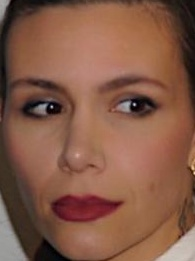

In [ ]:
from IPython.display import Image as IPImage, display
display(IPImage("face_selfie.jpg"))


# Etapa 7 - Comparação entre as duas imagens

In [ ]:
!pip install deepface --quiet

from deepface import DeepFace

result = DeepFace.verify(
    img1_path="face_cnh.jpg",
    img2_path="face_selfie.jpg",
    enforce_detection=False
)

print("✅ Mesma pessoa?" if result["verified"] else "❌ Pessoas diferentes")
print("🔒 Confiança (similarity score):", result["distance"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00
25-06-19 10:17:09 - Directory /root/.deepface has been created
25-06-19 10:17:09 - Directory /root/.deepface/weights has been created
25-06-19 10:17:11 - vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5
100%|██████████| 580M/580M [00:05<00:00, 109MB/s] 


✅ Mesma pessoa?
🔒 Confiança (similarity score): 0.32669658270202484


# Etapa 8 - Extração do Nome no Comprovante e Comparação com o Nome na CNH

Novamente vamos utilizar o Azure Form Recognizer para a etapa de extração do texto do comprovante de residência

In [ ]:
poller = form_client.begin_analyze_document(
    model_id="prebuilt-read",
    document=BytesIO(comprovante_bytes)
)
result = poller.result()

texto_comprovante = "\n".join([line.content for page in result.pages for line in page.lines])

Agora vamos utilizar o Gemini para extrair o nome e endereço presentes nesse documento.

In [ ]:
!pip install google-generativeai




In [ ]:
from google import genai
from google.genai import types
import base64
import json
import requests

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#@title Preenchimento do código do projeto
#@markdown Preencha abaixo o código do teu projeto na GCP. <br/>
#@markdown Após preenchimento do código, execute essa célula.   <br/>

project_id = ""  #@param {type: "string"}
location = ""  #@param {type: "string"}

llm_model = "gemini-2.0-flash-lite-001" # @param ["gemini-2.0-flash-001","gemini-2.0-flash-lite-001","gemini-1.5-flash-002"] {"allow-input":true}
#@markdown ---
llm_client = genai.Client( vertexai=True, project=project_id, location=location, )

In [ ]:
llm_agent_config = types.GenerateContentConfig(
    candidate_count=1,
    temperature=0.0,
    top_p=1,
    top_k=40,
    max_output_tokens=256,
    response_modalities=["TEXT"],
    safety_settings=[
        types.SafetySetting(category=types.HarmCategory.HARM_CATEGORY_HATE_SPEECH, threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH),
        types.SafetySetting(category=types.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT, threshold=types.HarmBlockThreshold.BLOCK_ONLY_HIGH),
        types.SafetySetting(category=types.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT, threshold=types.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE),
        types.SafetySetting(category=types.HarmCategory.HARM_CATEGORY_HARASSMENT, threshold=types.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE),
    ],
    response_mime_type="application/json",
    system_instruction=[
        "Você é um agente de extração de dados estruturados a partir de documentos.",
        "Responda sempre em JSON válido conforme o schema abaixo.",
        "Não inclua explicações ou comentários.",
    ],
    response_schema={
        "type": "object",
        "properties": {
            "nome_completo": {"type": "string"},
            "cpf": {"type": "string"},
            "endereco": {"type": "string"}
        },
        "required": ["nome_completo"]
    }
)


In [ ]:
# Construindo o prompt para o agente
prompt = f"""
A seguir está o conteúdo textual de um comprovante de residência. Extraia as seguintes informações:

- nome_completo (obrigatório)
- cpf (se estiver presente)
- endereco (se estiver presente)

Retorne apenas um objeto JSON válido, de acordo com o schema definido pelo sistema.

Texto do comprovante:
{texto_comprovante}
"""

# Gerar conteúdo com configuração personalizada
llm_ret = llm_client.models.generate_content(
    model=llm_model,
    contents=[prompt],
    config=llm_agent_config
)
display(llm_ret)
# Mostrar resultado
print("🔎 JSON extraído do comprovante:")
print(llm_ret.text)



In [ ]:
texto_json = llm_ret.text

In [ ]:
import json
dados_comprovante = json.loads(texto_json)
print(dados_comprovante)

In [ ]:
nome_completo

'PRISCILLA CORREA BISOGNIN'

# Etapa 9 - Comparação dos Nomes nos dois Documentos Fornecidos

In [ ]:
import unicodedata

def normalizar(nome):
    # Remove acentos, espaços extras e converte para minúsculas
    nome = nome.strip().lower()
    nome = unicodedata.normalize("NFKD", nome).encode("ASCII", "ignore").decode("utf-8")
    return nome

# Nomes de origem
nome_cnh = nome_completo
nome_comprovante = dados_comprovante["nome_completo"]

# Normalizados
nome_cnh_norm = normalizar(nome_cnh)
nome_comprovante_norm = normalizar(nome_comprovante)

# Comparação
if nome_cnh_norm == nome_comprovante_norm:
    print("✅ Os nomes coincidem. Documentos compatíveis.")
else:
    print("❌ Os nomes são diferentes. Verificação necessária.")

print("Nome CNH:", nome_cnh)
print("Nome Comprovante:", nome_comprovante)


✅ Os nomes coincidem. Documentos compatíveis.
Nome CNH: PRISCILLA CORREA BISOGNIN
Nome Comprovante: PRISCILLA CORREA BISOGNIN
